<a href="https://colab.research.google.com/github/das007/DeepLearning/blob/master/ShallowNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shallow Neural Network

In [ ]:
# Package Imports 
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Sigmoid Activation Function
def sigmoid(Z):
  """
    Compute sigmoid of Z
    Arguments:
      Z: A scalar or numpy array of any size

    Returns:
      s: sigmoid(Z)
  """
  s = 1/(1+np.exp(-Z))
  return s

### 1. Dataset

In [ ]:
def load_planar_dataset():
  m = 400 # number of examples
  N = int(m/2) # number of points per class : int(400/2)=200
  D = 2 # dimensionality
  X = np.zeros((m,D)) # data matrix where each row is a single example : dims(400,2)
  Y = np.zeros((m,1), dtype='uint8') # Labels vector (0 for red, 1 for blue) : dims(400,1)
  a = 4 # maximum ray of the flower 

  for j in range(2):
    ix = range(N*j, N*(j+1)) # j=0 : range(0,200), j=1 : range(200,400)
    t = np.linspace(j*3.12, (j+1)*3.12, N) + np.random.randn(N)*0.2 # theta
    r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    Y[ix] = j

  X = X.T
  Y = Y.T

  return X, Y

In [ ]:
X, Y = load_planar_dataset()

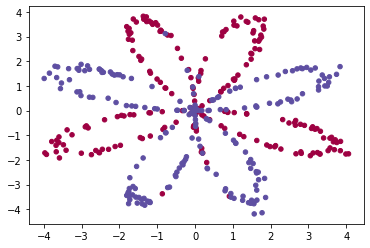

In [ ]:
# Visualize the dataset
plt.scatter(X[0,:], X[1,:], c=Y, s=20, cmap=plt.cm.Spectral);

In [ ]:
shape_X = X.shape
shape_Y = Y.shape
m = shape_X[1]
print('Shape of X:'+str(shape_X))
print('Shape of Y:'+str(shape_Y))
print('Training Examples :'+str(m))

Shape of X:(2, 400)
Shape of Y:(1, 400)
Training Examples :400


### 2. Plot Decision Boundary

In [ ]:
def plot_decision_boundary(model, X, y):
  # Set min and max values and give it some padding
  x_min, x_max = X[0,:].min()-1, X[0,:].max()+1
  y_min, y_max = X[1,:].min()-1, X[1,:].max()+1
  h = 0.01

  # Generate a grid of points with distance h between them
  xx, yy = np.meshgrid(np.arange(x_min,x_max,h), np.arange(y_min,y_max,h))

  # Predict the function value for the whole grid
  Z = model(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  # Plot the contour and training examples
  plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
  plt.ylabel('x2')
  plt.xlabel('x1')
  plt.scatter(X[0,:], X[1,:], c=y, cmap=plt.cm.Spectral)

### 3. Simple Logistic Regression

In [ ]:
import sklearn
import sklearn.linear_model

classifier = sklearn.linear_model.LogisticRegressionCV();
classifier.fit(X.T, Y.T)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

Accuracy of logistic regression: 53 %
Accuracy of logistic regression: 53.750000%


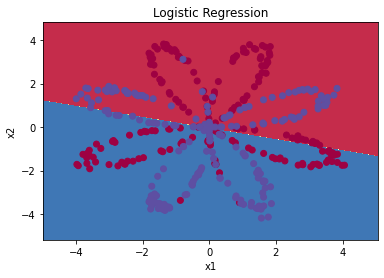

In [ ]:
plot_decision_boundary(lambda x: classifier.predict(x), X, Y)
plt.title("Logistic Regression")

predictions = classifier.predict(X.T)
print('Accuracy of logistic regression: %d '% float((np.dot(Y,predictions) + np.dot(1-Y, 1-predictions))/float(Y.size)*100) + '%')
match=(Y==predictions)
pred_percentage = float(float(np.sum(match))/float(Y.size))*100
print('Accuracy of logistic regression: %f' % pred_percentage + '%')

In [ ]:
type(classifier)

sklearn.linear_model._logistic.LogisticRegressionCV

In [ ]:
x=np.linspace(0,1,11)
print(x)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


## 4. Neural Network Model

<img src="https://drive.google.com/uc?export=view&id=1J0dWNhEsDpI3Rss8DUzgRvt_35_hex2n" style="width:600px;height:300px;">

The general methodology to build a Neural Network is to:
1. Define the Neural Network structure ( # of input units,  # of hidden units, etc ).
2. Initialize the model's parameters ( W,b )
3. Loop:
    1. Implement Forward Propagation
    2. Compute loss (J)
    3. Implement Backward propagation to get the gradients
    4. Update parameters (Gradient Descent)

### 4.1 Defining the Network Structure

In [ ]:
def layer_sizes(X, Y):
  """
    Arguments :
      X: input dataset of shape (input_size, # of examples)
      Y: labels of shape (output_size, # of examples)

    Return value:
      n_x: the size of the input layer
      n_h: the size of hidden layer
      n_y: the size of output layer
  """

  n_x = X.shape[0]
  n_h = 4
  n_y = Y.shape[0]

  return (n_x,n_h,n_y)


### 4.2 Initialize the model's parameters

In [ ]:
def initialize_parameters(n_x, n_h, n_y):
  """
    Arguments:
      n_x: the size of the input layer
      n_h: the size of hidden layer
      n_y: the size of output layer

    Returns:
      params: Python dictionary containing your parameters:
                W1: weight matrix of shape (n_h,n_x)
                b1: bias vector of shape (n_h,1)
                W2: weight matrix of shape (n_y,n_h)
                b2: bias vector of shape (n_y,1)
  """

  W1 = np.random.randn(n_h,n_x)*0.01 # Multiplying by 0.01 to initialize W1 with small non-zeros values closer to 0
  b1 = np.zeros((n_h,1))
  W2 = np.random.randn(n_y,n_h)*0.01
  b2 = np.zeros((n_y,1))

  params = {"W1":W1,
            "b1":b1,
            "W2":W2,
            "b2":b2}

  return params

### 4.3 The Loop
#### 4.3.1 Implement Forward Propagation

In [ ]:
def forward_propagation(X, parameters):
  """
    Arguments:
      X: input data of size (n_x, m)
      parameters: python dictionary containing your parameters (output of initialize_parameters())
    
    Returns:
      A2: The sigmoid output of the second activation
      cache: a dictionary containing Z1, A1, Z2, and A2
  """

  # Retrieve each params from dictionary parameters
  W1 = parameters["W1"]
  b1 = parameters["b1"]
  W2 = parameters["W2"]
  b2 = parameters["b2"]

  # Implement forward propagation to calculate A2 (probabilities)
  Z1 = np.matmul(W1,X)+b1 # (4,2)*(2,400)=(4,400)
  A1 = np.tanh(Z1) # (4,400)
  Z2 = np.matmul(W2,A1)+b2 # (1,4)*(4,400)= (1,400)
  A2 = sigmoid(Z2) # (1,400)

  assert(A2.shape == (1,X.shape[1]))

  cache = {"Z1":Z1,
           "A1":A1,
           "Z2":Z2,
           "A2":A2}

  return A2, cache

#### 4.3.2 Compute Cost (Cross-Entropy Loss)
Now that we have computed $A^{[2]}$ (in the Python variable "`A2`"), which contains $a^{[2](i)}$ for every example, we can compute the cost function as follows:

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small$$

In [ ]:
def compute_cost(A2, Y):
  """
    Computes cross-entropy loss given in equation above.

    Arguments:
      A2: The sigmoid output of the 2nd activation of shape (1, # of examples)
      Y: TRUE labels vector of shape (1, # of examples)

    Returns:
      cost: cross entropy cost
  """

  m = Y.shape[1] # number of examples
  logprobs = np.multiply(Y,np.log(A2)) + np.multiply(1-Y,np.log(1-A2))    # shape(logprobs): (1, # of examples)
  cost = -np.sum(logprobs)/m                                              # shape(cost): const float 

  assert(isinstance(cost, float))

  return cost

### 4.3.3 Backward Propagation

$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$

<img src="https://drive.google.com/uc?export=view&id=1HG8-F5X9GhBT5lPHcbbnFwcWDtSBKbsg" style="width:600px;height:300px;">
    

In [ ]:
def backward_propagation(parameters, cache, X, Y):
  """
    Implement the backward propagation using the equations above.

    Arguments:
      parameters: python dictionary containing all the paramaters
      cache: a dictionary containing Z1, A1, Z2 and A2
      X: input data of shape (input_size, # of examples)
      Y: "true" labels vector of shape (output_size, # of examples)

    Returns:
      gradients: python dictionary containing the gradients w.r.t different parameters
                 (dW1, db1, dW2, db2)
  """

  m = X.shape[1] # no. of examples

  # Retrieve W1 and W2 from dict "parameters"
  W1 = parameters["W1"]
  W2 = parameters["W2"]

  # Retrieve A1 and A2 from dict "cache"
  A1 = cache["A1"]
  A2 = cache["A2"]

  # Backward propagation: calculate dW1, db1, dW2, db2
  dZ2 = (A2 - Y)/m # A2.shape = (1,no. of examples), Y.shape=(1,no. of examples) = dZ2.shape=(1,no. of examples)
  dW2 = np.matmul(dZ2,A1.T) # dW2.shape = dZ2.shape(1,no. of examples)*A1.T.shape(no. of examples,4) = (1,4)
  db2 = np.sum(dZ2, axis=1, keepdims=True) # db2.shape(1,1) = np.sum(dZ2.shape(1,no. of examples))
  dZ1 = np.multiply(np.matmul(W2.T,dZ2),(1-np.square(A1))) # dZ1.shape(4,no. of examples) = (4,1)x(1,no. of examples)*(4,no. of examples) = (4,1)x(1,400)*(4,400) = (4,400)
  dW1 = np.matmul(dZ1,X.T) # dW1.shape(4,2) = (4,400)x(400,2)
  db1 = np.sum(dZ1, axis=1, keepdims=True) # np.sum(dZ1.shape(4,400)).shape = (4,1)

  gradients = {"dW1":dW1,
               "db1":db1,
               "dW2":dW2,
               "db2":db2}

  return gradients

### 4.3.4 Update Parameters (Gradient Descent Update Rule)

**General gradient descent rule**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.

The gradient descent algorithm with a good learning rate converges and a bad learning rate diverges.

In [ ]:
def update_parameters(parameters, gradients, learning_rate=1.2):
  """
    Updates parameters using the gradient descent update rule given above.

    Arguments:
      parameters: python dictionary containing all parameters (W1,b1,W2,b2)
      gradients: python dictionary containing all gradients (dW1,db1,dW2,db2)

    Returns:
      parameters: python dictionary with updated parameters
  """

  # Retrieve each param from dictionary "parameters"
  W1 = parameters["W1"]
  b1 = parameters["b1"]
  W2 = parameters["W2"]
  b2 = parameters["b2"]

  # Retrieve each gradient from dictionary "gradients"
  dW1 = gradients["dW1"]
  db1 = gradients["db1"]
  dW2 = gradients["dW2"]
  db2 = gradients["db2"]

  # Update rule for each parameter
  W1 = W1 - learning_rate*dW1
  b1 = b1 - learning_rate*db1
  W2 = W2 - learning_rate*dW2
  b2 = b2 - learning_rate*db2

  parameters = {"W1":W1,
                "b1":b1,
                "W2":W2,
                "b2":b2}

  return parameters

### 4.4 Neural Network Model

Integrating 4.1, 4.2 and 4.3 sections to create a neural network

In [ ]:
def nn_model(X, Y, n_h, num_iterations=10000, learning_rate=1.2, print_cost=False):
  """
    Arguments:
      X: dataset of shape (2, no. of examples)
      Y: labels of shape (1, no. of examples)
      n_h: size of hidden layer
      num_iterations: no. of iterations in gradient descent loop
      print_cost: if True, print the cost every 1000 iterations

    Returns:
      parameters: parameters learned by the model. They can then be used to predict.
  """

  n_x, _ , n_y = layer_sizes(X, Y)

  # Initialize parameters
  parameters = initialize_parameters(n_x, n_h, n_y)

  # Loop (Gradient Descent)
  for i in range(0, num_iterations):
    # Step 1: Forward Propagation
    A2, cache = forward_propagation(X, parameters)

    # Step 2: Compute cost
    cost = compute_cost(A2, Y)

    # BackPropagation
    gradients = backward_propagation(parameters, cache, X, Y)

    # Gradient Descent parameter update
    parameters = update_parameters(parameters, gradients, learning_rate)

    # Print cost every 1000 iterations
    if print_cost and i%1000==0:
      print("Cost of iteration %i: %f" %(i, cost))

  # Return learnt parameters
  return parameters

### 4.5 Predictions

predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$ 

In [ ]:
def predict(learned_parameters, X):
  """
    Using the learned parameters, predict a class for each example in X

    Arguments:
      learned_parameters: python dict containing the learned params (W1, b1, W2, b2)
      X: input data of size (n_x, m), where m=no. of examples, n_x = input dimensions(or number of features)

    Returns:
      predictions: vector of predictions of the model (red:0 / blue:1)
  """

  # Compute probabilities using forward prop and classify to class 0/1 using threshold=0.5
  A2, cache = forward_propagation(X, learned_parameters)
  predictions = (A2>0.5) # predictions.shape(1,no. of examples)

  return predictions

It is time to run the model and see how it performs on a planar dataset.

(2, 400) (1, 400)
Cost of iteration 0: 0.693162
Cost of iteration 1000: 0.214927
Cost of iteration 2000: 0.204822
Cost of iteration 3000: 0.204465
Cost of iteration 4000: 0.203150
Cost of iteration 5000: 0.202324
Cost of iteration 6000: 0.201742
Cost of iteration 7000: 0.201303
Cost of iteration 8000: 0.200953
Cost of iteration 9000: 0.200663


Text(0.5, 1.0, 'Decision Boundary for hidden layer size of 4')

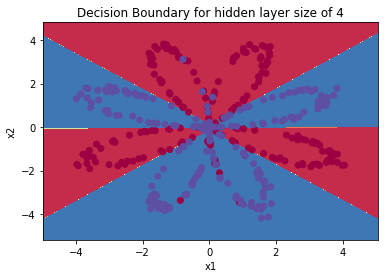

In [ ]:
n_h=4 # no. of hidden units
print(X.shape, Y.shape)
# Build a model with a n_h dimensional hidden layer
learned_parameters = nn_model(X, Y, n_h, num_iterations=10000, learning_rate=1.2, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(learned_parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size of "+ str(n_h))

In [ ]:
# Print Accuracy
predictions = predict(learned_parameters, X)
print('Accuracy of Shallow Neural Network: %d '% float((np.dot(Y,predictions.T) + np.dot(1-Y, 1-predictions.T))/float(Y.size)*100) + '%')
match=(Y==predictions)
pred_percentage = float(float(np.sum(match))/float(Y.size))*100
print('Accuracy of Shallow Neural Network: %f' % pred_percentage + '%')

Accuracy of Shallow Neural Network: 91 %
Accuracy of Shallow Neural Network: 91.750000%


Accuracy is really high compared to Logistic Regression. The model has learnt the leaf patterns of the flower! Neural networks are able to learn even highly non-linear decision boundaries, unlike logistic regression.

### 4.6 Tuning hidden layer size

Accuracy for 1 hidden units: 70.0 %
Accuracy for 2 hidden units: 69.25 %
Accuracy for 3 hidden units: 91.5 %
Accuracy for 4 hidden units: 91.25 %
Accuracy for 5 hidden units: 91.5 %
Accuracy for 20 hidden units: 93.25 %
Accuracy for 50 hidden units: 91.75 %


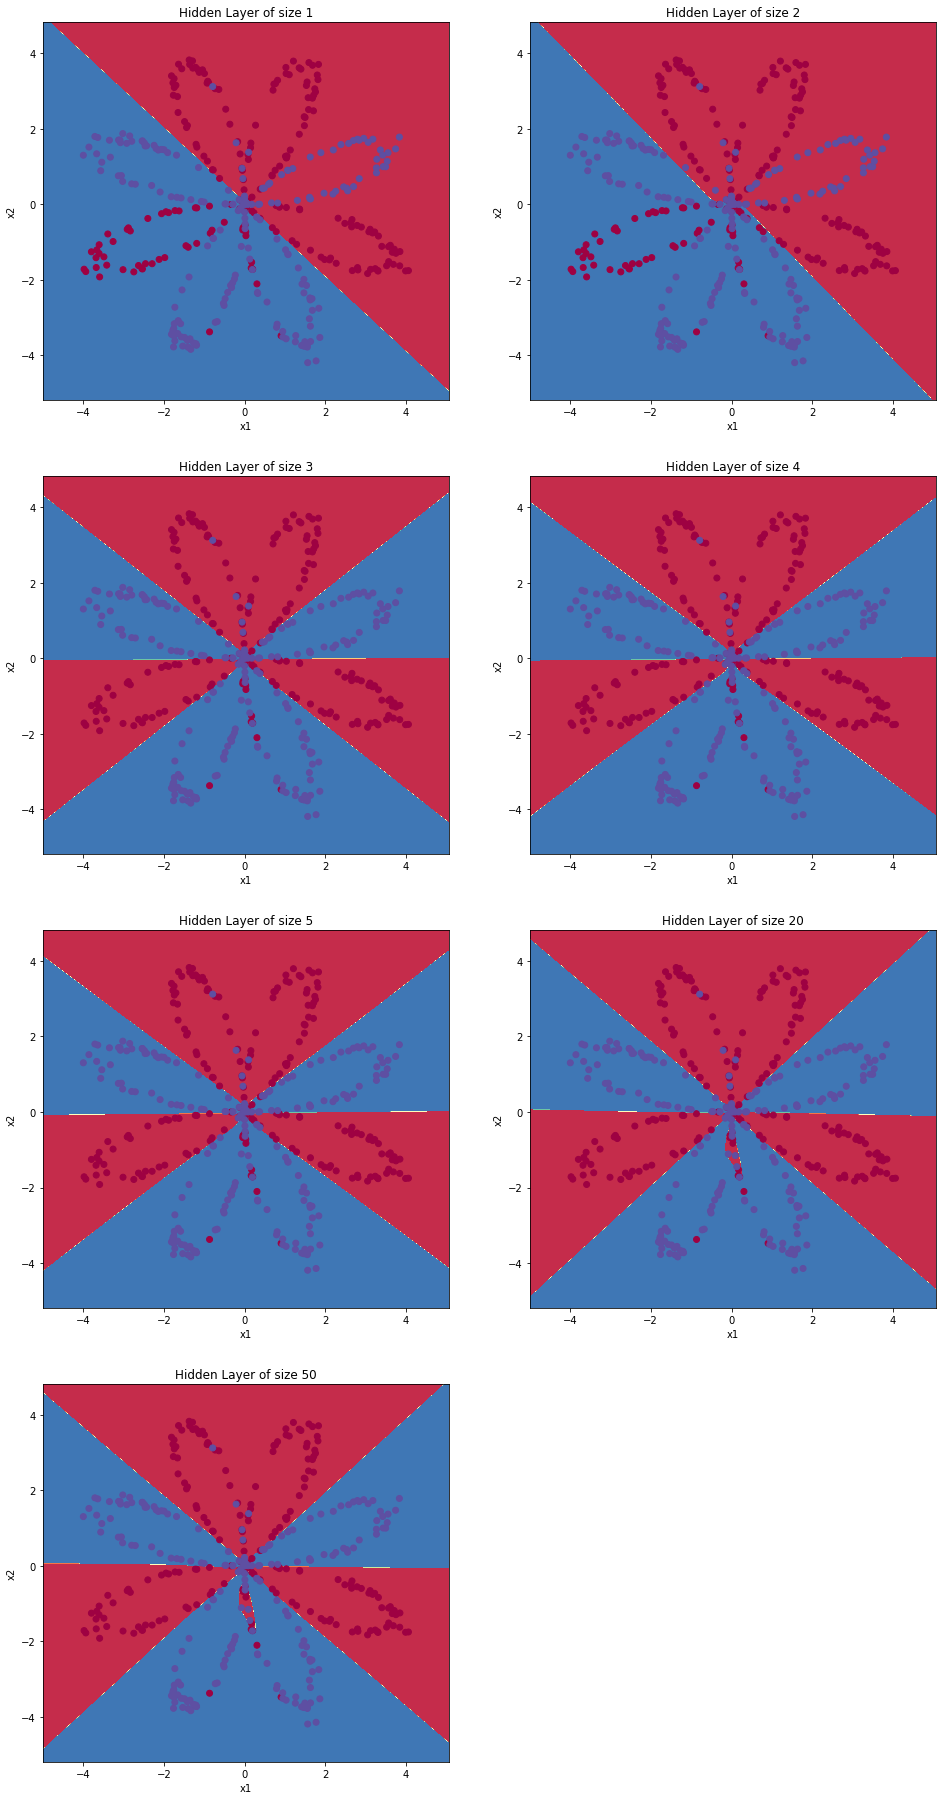

In [ ]:
plt.figure(figsize=(16,32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
# hidden_layer_sizes = [500]

for i, n_h in enumerate(hidden_layer_sizes):
  plt.subplot(4, 2, i+1)
  plt.title('Hidden Layer of size %d' % n_h)
  learned_parameters = nn_model(X, Y, n_h, num_iterations=5000)
  plot_decision_boundary(lambda x: predict(learned_parameters, x.T), X, Y)
  predictions = predict(learned_parameters, X)
  match=(Y==predictions)
  accuracy = float(float(np.sum(match))/float(Y.size))*100
  print("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

**Interpretation:**



*   The larger models (with more hidden units) are able to fit the training set better, until eventually the largest model overfits the data.
*   The best hidden layer size seems to be around n_h=5. Indeed, a value around here seems to fit the data well without also incurring noticable overfitting.

*   Regularization lets us use very large models (such as n_h=50) without much overfitting.



